# Assignment 3 (Part 2): Neural Networks using PyTorch (Starter)

* Student Name: Paul Barrett
* Enrollment Status: UNDERGRADUATE STUDENT

In this assignment, you will fit neural network models to each of the six synthetic datasets you used for first assignment.  Your goal will be to obtained the lowest average test loss across all datasets using a single neural network architecture and set of optimization parameters.

Things to include in the writeup:

* For the best model you found:
  * The source code for your "Model Architecture Parameters".
  * The source code for the "Training Parameters".
  * For each dataset, the plot of the training error and the visualization of the final classifier (feel free to cut and paste).
  * The final average test loss your model obtained (feel free to cut and paste).
* If you did not obtain an average test loss below 0.1, then you must also include the following:
   * The code for at least three additional "Model Architecture Parameters" that you tried along with their average test losses. 
   * A description of the process you used to try to set the "Training Parameters" and "Model Architecture Parameters".

# Setup Environment

This is designed to work in Google Colab.  You may need to do some of these from the command line if you are using your own installation of Jupyter/Python.

In [2]:
!pip3 install torchvision

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Build some simple datasets

These should look familiar.

In [4]:
def gen_from_mean_and_cov(means, covs, labels, mode='train', count=100):
  
  np.random.seed(0) if mode == 'train' else np.random.seed(1)
      
  vals = np.array([]).reshape(0,len(means[0])+1)

  for i, (mean,cov,label) in enumerate(zip(means,covs,labels)):
    vals_new = np.random.multivariate_normal(mean,cov,count)/10.;
    vals_new = np.hstack([vals_new,np.ones((vals_new.shape[0],1))*label])
    vals = np.vstack([vals,vals_new])    

  df = pd.DataFrame(data=vals,columns=['x1','x2','y'])

  return df

# There are 6 different simple training datasets

datasets = {
    'train1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0]),
    'train2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1]),
    'train3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0]),
    'train4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0]),
    'train5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0]),
    'train6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1]),
    'test1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0],mode='test'),
    'test2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1],mode='test'),
    'test3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0],mode='test'),
    'test4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0],mode='test'),
    'test5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0],mode='test'),
    'test6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1],mode='test')
}

df = datasets['train1']

## Helpful Code

In [5]:
# visualize the classifer
def vis2d_classifier(net,data):
  
  # create the domain for the plot
  x1_min = data.x1.min()
  x1_max = data.x1.max()
  x2_min = data.x2.min()
  x2_max = data.x2.max()

  X1,X2 = np.meshgrid(
      np.linspace(x1_min, x1_max, 200),
      np.linspace(x2_min, x2_max, 200))

  # convert it into a matrix (rows are locations, columns are features)
  vis_data = np.hstack([X1.reshape(-1,1),X2.reshape(-1,1)])

  # classify each location
  vis_sco = net.eval()(torch.tensor(vis_data,dtype=torch.float32))

  # convert back into image shapes
  vis_sco = vis_sco.detach().numpy().reshape(X1.shape)
  vis_class = vis_sco > .5;
  
  #
  # Make the plots
  #

  # show the function value in the background
  cs = plt.imshow(vis_sco,
    extent=(x1_min,x1_max,x2_max,x2_min), # define limits of grid, note reversed y axis
    cmap=plt.cm.jet, vmin=0.,vmax=1.)
  plt.clim(0,1) # defines the value to assign the min/max color

  # draw the line on top
  levels = np.array([.5])
  cs_line = plt.contour(X1,X2,vis_sco,levels, colors='k')

  plt.scatter(data.x1,data.x2,c=data.y,edgecolors='w',cmap=plt.get_cmap('jet'))

  # add a color bar
  CB = plt.colorbar(cs)

  plt.show()

# Setup the model

** TASK: ** Your job is to define a neural network that performs well on this dataset.  See the last cell for a comparison to the best possible model.  You will need to find a good combination of training parameters and model parameters.  You don't actually need to modify this code, just define a good set of parameters.


In [55]:
def build_network(hidden_nodes=[4,5], activation_fn=nn.ReLU, include_batchnorm=False):

  layers = []

  prev_nodes = 2 # 2 input values
  for out_nodes in hidden_nodes:
    layers.append(nn.Linear(prev_nodes, out_nodes))
    if include_batchnorm:
      layers.append(nn.BatchNorm1d(out_nodes))
    layers.append(activation_fn())
    
    prev_nodes = out_nodes

  layers.append(nn.Linear(prev_nodes,1))
  layers.append(nn.Sigmoid())
    
  return torch.nn.Sequential(*layers)

## Visualize a random classifier

C:\Users\Paul\Miniconda3\envs\cs460g\lib\site-packages\matplotlib\contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


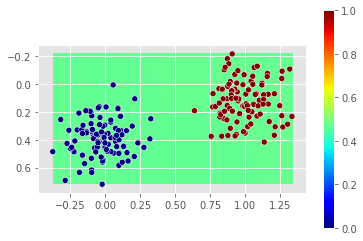

In [58]:
vis2d_classifier(build_network(),df)

# Optimize Networks for Each Dataset

The code below optimizes the model.  It works as follows:

* It computes gradient updates on mini-batches of training examples.  Each mini-batch contains `batch_size` examples.
* There are five training rounds, and it runs a fixed number of epochs per training round (`epochs_per_round`).
* After each training round, the learning rate is reduced by a multiplicative factor (`learning_rate_decay`).

Dataset 1, Round [4], Epoch [400/400], Train Loss: 0.0001, Test Loss: 0.0000


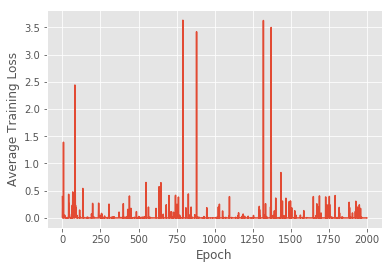

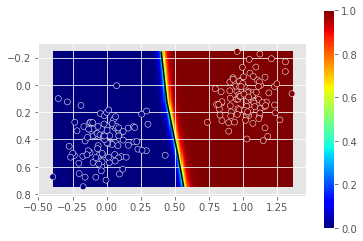

Dataset 2, Round [4], Epoch [400/400], Train Loss: 0.0000, Test Loss: 0.0001


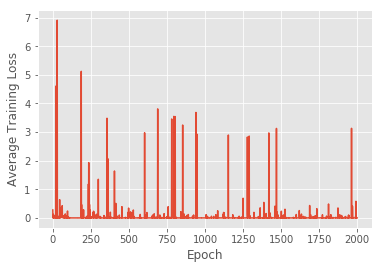

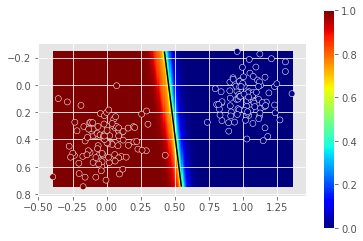

Dataset 3, Round [4], Epoch [400/400], Train Loss: 0.2214, Test Loss: 0.0342


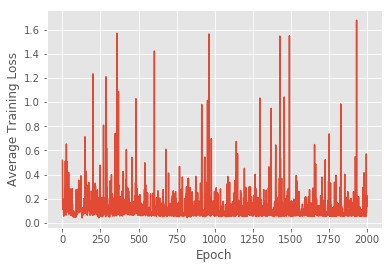

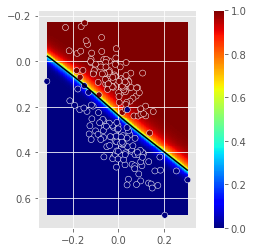

Dataset 4, Round [4], Epoch [400/400], Train Loss: 0.4443, Test Loss: 0.1764


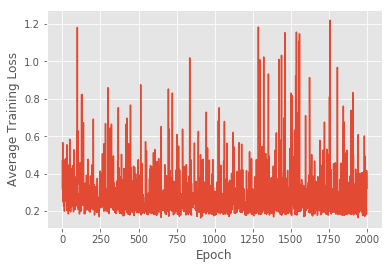

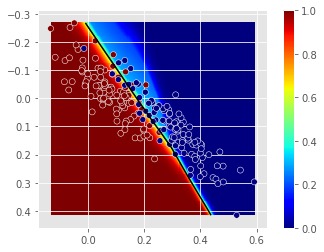

Dataset 5, Round [4], Epoch [400/400], Train Loss: 0.0926, Test Loss: 0.0768


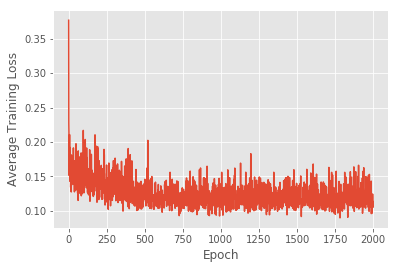

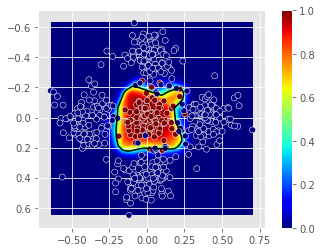

Dataset 6, Round [4], Epoch [400/400], Train Loss: 0.7916, Test Loss: 0.1661


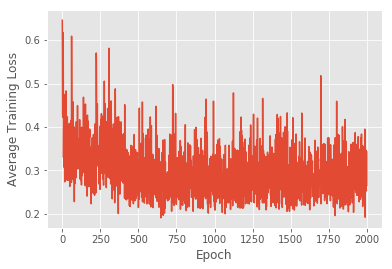

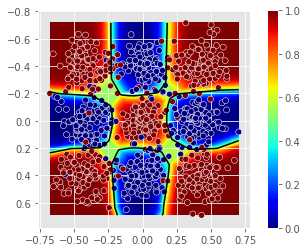

In [65]:
#
# Training Parameters (INCLUDE THESE IN YOUR WRITEUP)
#

opt_method = torch.optim.Adam
learning_rate = .075
batch_size = 64 # number of examples to use to compute each gradient update
epochs_per_round = 400 # number of times to loop over the dataset 
weight_decay = 0.1e-5
learning_rate_decay = .01 # amount to decrease learning rate after each training round

#
# Model Architecture Parameters (INCLUDE THESE IN YOUR WRITEUP)
#

activation_fn = nn.ReLU
include_batchnorm = True
hidden_nodes=[100,100]

#
# You shouldn't modify anything below here, but you should definitely read it
# to understand what is happening.
#

# Store average losses
test_losses = []

# Fit models to each datasets
for data_id in range(1,7):

  # gather the train/test datasets
  df_train = datasets['train{}'.format(data_id)]
  df_test = datasets['test{}'.format(data_id)]

  # initialize a model
  net = build_network(hidden_nodes=hidden_nodes, activation_fn=activation_fn, include_batchnorm=include_batchnorm)

  # define the loss
  loss_function = nn.BCELoss()

  # build the torch tensors
  train_dataset = TensorDataset(
      torch.tensor(df_train[['x1','x2']].values,dtype=torch.float32),
      torch.tensor(df_train[['y']].values,dtype=torch.float32)
  )
  
  feats_test = torch.tensor(df_test[['x1','x2']].values,dtype=torch.float32)
  vals_test = torch.tensor(df_test[['y']].values, dtype=torch.float32)

  # use this to yield random mini-batches
  train_loader = DataLoader(dataset=train_dataset,
                            batch_size=batch_size, 
                            shuffle=True)
  
  training_loss_per_epoch = []

  # run gradient descent for multiple rounds, decreasing learning rate each time
  for training_round in range(5):

    optimizer = opt_method(net.parameters(), lr=learning_rate*learning_rate_decay**(training_round), weight_decay=weight_decay)
    
    for epoch in range(epochs_per_round):
      
      loss_accum = 0.0
      
      # iterate over mini-batches
      for i_batch, (feats, vals) in enumerate(train_loader):

        optimizer.zero_grad();               # Intialize the gradient accumulators to all zeros
        outputs = net(feats);                # Forward pass: compute the output class given a image
        loss = loss_function(outputs, vals); # Compute the loss: difference between the output class and the pre-given label
        loss.backward();                     # Backward pass: compute the weight
        optimizer.step();                    # Optimizer: update the weights of hidden nodes
        
        loss_accum += float(loss)

      training_loss_per_epoch.append(loss_accum/i_batch)
  
  # compute and store test loss
  test_loss = loss_function(net(feats_test), vals_test)
  test_losses.append(float(test_loss))    
  print('Dataset %d, Round [%d], Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' % (data_id, training_round, epoch+1, epochs_per_round, float(loss), float(test_loss)))

  # plot training loss to help diagnose convergence issues
  plt.figure()
  plt.plot(training_loss_per_epoch)
  plt.xlabel('Epoch')
  plt.ylabel('Average Training Loss')

  # show the final classifier
  plt.figure()
  vis2d_classifier(net,df_test)

## Compute the Average Test Loss

In [67]:
print('The average test loss across all datasets for your model was {:2.3}.'.format(np.array(test_losses).mean()))

The average test loss across all datasets for your model was 0.0756.


The best average loss I obtained was around 0.078 (although this varies a bit every time due to the random initialization).  Can you do better?